In [1]:
import os

import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pandas as pd
import numpy as np
from moveminer.metrics.distance_calculation import HaversineDistanceCalculation

from shapely.wkt import loads
from shapely.geometry import Point


c:\Users\edgar\anaconda3\envs\moveminer\lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\edgar\anaconda3\envs\moveminer\lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
gdf = gpd.read_file("./anglova_metrics_enriched/points_matcheds.csv")

In [5]:
output_path = "./assets/On The Road/"

In [6]:
def save_plot(filename):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(
        f"{output_path}/{filename}.png",
        bbox_inches="tight",
    )
    plt.savefig(
        f"{output_path}/{filename}.pdf",
        bbox_inches="tight",
    )

In [3]:

# Convert 'geometry_matched' column to shapely Point objects if it's in WKT format
gdf["geometry_matched"] = gdf["geometry_matched"].apply(lambda geom: loads(geom) if isinstance(geom, str) else geom)

# Now extract the x and y coordinates
gdf["geometry_matched_x"] = gdf["geometry_matched"].apply(lambda point: point.x if isinstance(point, Point) else None)
gdf["geometry_matched_y"] = gdf["geometry_matched"].apply(lambda point: point.y if isinstance(point, Point) else None)



# Ensure the columns used in the calculation are converted to float
gdf["y"] = gdf["y"].astype(float)
gdf["x"] = gdf["x"].astype(float)
gdf["geometry_matched_y"] = gdf["geometry_matched_y"].astype(float)
gdf["geometry_matched_x"] = gdf["geometry_matched_x"].astype(float)

# Perform the Haversine distance calculation
haversine = HaversineDistanceCalculation()
gdf["match_distance"] = gdf.apply(
    lambda row: haversine.calculate(
        row["y"],
        row["x"],
        row["geometry_matched_y"],
        row["geometry_matched_x"],
    ),
    axis=1,
)
gdf["on_the_road"] = gdf['match_distance'] < 0.01

In [4]:
correlation = gdf['match_distance'].corr(gdf['speed'])
print("Correlation between match_distance and speed:", correlation)

Correlation between match_distance and speed: -0.40448827580476127


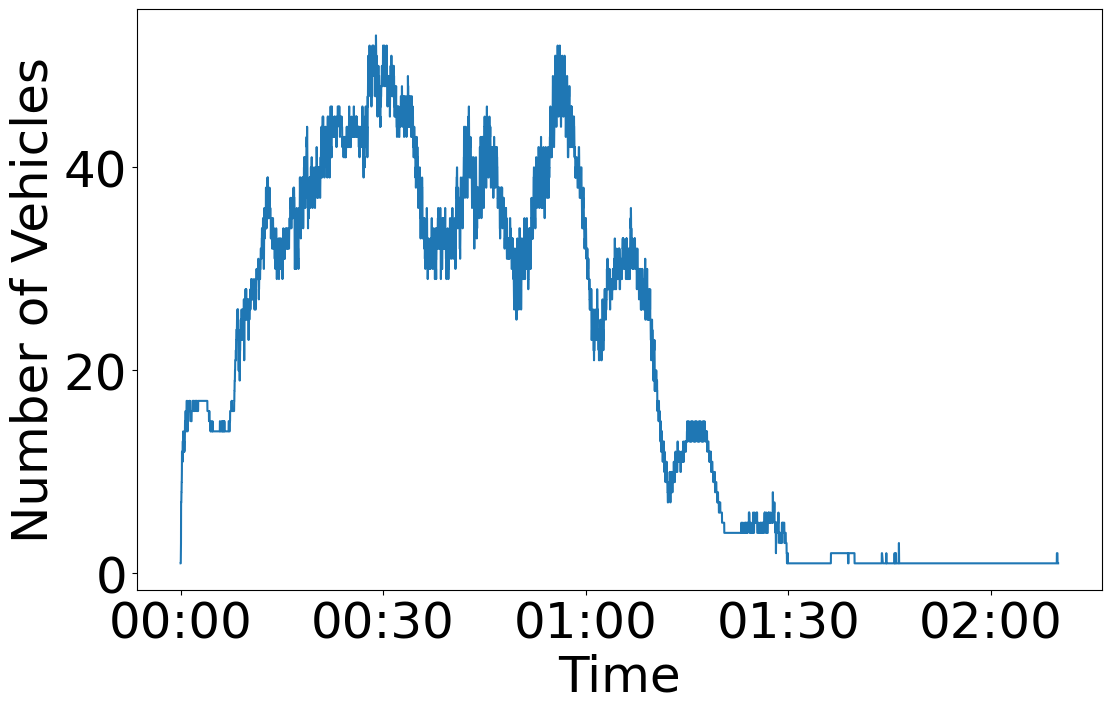

In [11]:
# Convert the 't' column to datetime if not already done
gdf["t"] = pd.to_datetime(gdf["t"])

# Group by time and count the number of vehicles "on_the_road"
plt.rcParams.update({"font.size": 36, "font.weight": "normal"})
on_the_road_over_time = gdf[gdf["on_the_road"]].groupby("t").size()
fig, ax = plt.subplots(figsize=(12, 8))
on_the_road_over_time.plot(ax=ax,  xlabel="Time", ylabel="Number of Vehicles")

if not on_the_road_over_time.empty:
    # Convert the index to datetime objects if it's not already
    if not isinstance(on_the_road_over_time.index, pd.DatetimeIndex):
        on_the_road_over_time.index = pd.to_datetime(on_the_road_over_time.index)

    # Determine the first and last timestamp
    start_time = on_the_road_over_time.index.min()
    end_time = on_the_road_over_time.index.max()

    # Generate timestamps at 10-minute intervals
    ten_minute_intervals = pd.date_range(start=start_time.floor('30min'),
                                         end=end_time.ceil('30min'),
                                         freq='30min')

    # Filter these intervals to include only those present in your data's index
    tick_locations = on_the_road_over_time.index[on_the_road_over_time.index.isin(ten_minute_intervals)]

    # Set the x-axis ticks and labels
    ax.set_xticks(tick_locations)
    ax.set_xticklabels([t.strftime('%H:%M') for t in tick_locations], rotation=0, ha='center') # Removed seconds for cleaner labels

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()
else:
    print("Warning: No data to plot.")

save_plot("Anglova")
plt.show()